In [1]:
import sys
sys.path.append('..')
from par_segmentation import *
%matplotlib notebook

In [2]:
path = '/Users/blandt/Desktop/Data/PAR2 MAIN DATASET/Ctrl/220823_nwg338_tom4,15,60/03'
img = load_image(path + '/af_corrected.tif')
roi = np.loadtxt(path + '/ROI.txt')

In [3]:
straights = []
rois_new = []

In [4]:
iq = ImageQuantGradientDescent(img=img, roi=roi, sigma=3.5, descent_steps=300, rol_ave=5, 
                                lr=0.01, iterations=1, fit_outer=True, roi_knots=20, nfits=None, save_training=True)

In [5]:
# First iteration
iq.run()
iq.adjust_roi()
roi2 = iq.roi[0]

for i in iq.saved_vars[0::10]:
    a = tf.concat((i['offsets'], i['offsets'][:, :1]), axis=1)
    offsets_spline = create_offsets_spline(i['offsets'], iq.roi_knots, iq.periodic, iq.n, iq.nfits, [roi,]).numpy()
    roi_new = offset_coordinates(roi, iq.freedom * tf.math.tanh(offsets_spline[0]))
    roi_new_interp = interp_roi(roi_new)
    rois_new.append(roi_new_interp)
    straights.append(straighten(img, roi_new_interp, 50))

  0%|          | 0/300 [00:00<?, ?it/s]

Iteration 1 of 1


100%|██████████| 300/300 [00:10<00:00, 29.15it/s]


Time elapsed: 10.54 seconds 



In [6]:
# Second iteration
iq.run()
iq.adjust_roi()
roi3 = iq.roi[0]

for i in iq.saved_vars[0::10]:
    a = tf.concat((i['offsets'], i['offsets'][:, :1]), axis=1)
    offsets_spline = create_offsets_spline(i['offsets'], iq.roi_knots, iq.periodic, iq.n, iq.nfits, [roi2,]).numpy()
    roi_new = offset_coordinates(roi2, iq.freedom * tf.math.tanh(offsets_spline[0]))
    roi_new_interp = interp_roi(roi_new)
    rois_new.append(roi_new_interp)
    straights.append(straighten(img, roi_new_interp, 50))

  0%|          | 0/300 [00:00<?, ?it/s]

Iteration 1 of 1


100%|██████████| 300/300 [00:10<00:00, 29.43it/s]


Time elapsed: 10.44 seconds 



In [7]:
# # Third iteration
# iq.run()

# for i in iq.saved_vars[0::10]:
#     a = tf.concat((i['offsets'], i['offsets'][:, :1]), axis=1)
#     offsets_spline = create_offsets_spline(i['offsets'], iq.roi_knots, iq.periodic, iq.n, iq.nfits, [roi3,]).numpy()
#     roi_new = offset_coordinates(roi3, iq.freedom * tf.math.tanh(offsets_spline[0]))
#     roi_new_interp = interp_roi(roi_new)
#     rois_new.append(roi_new_interp)
#     straights.append(straighten(img, roi_new_interp, 50))

514


<IPython.core.display.Javascript object>


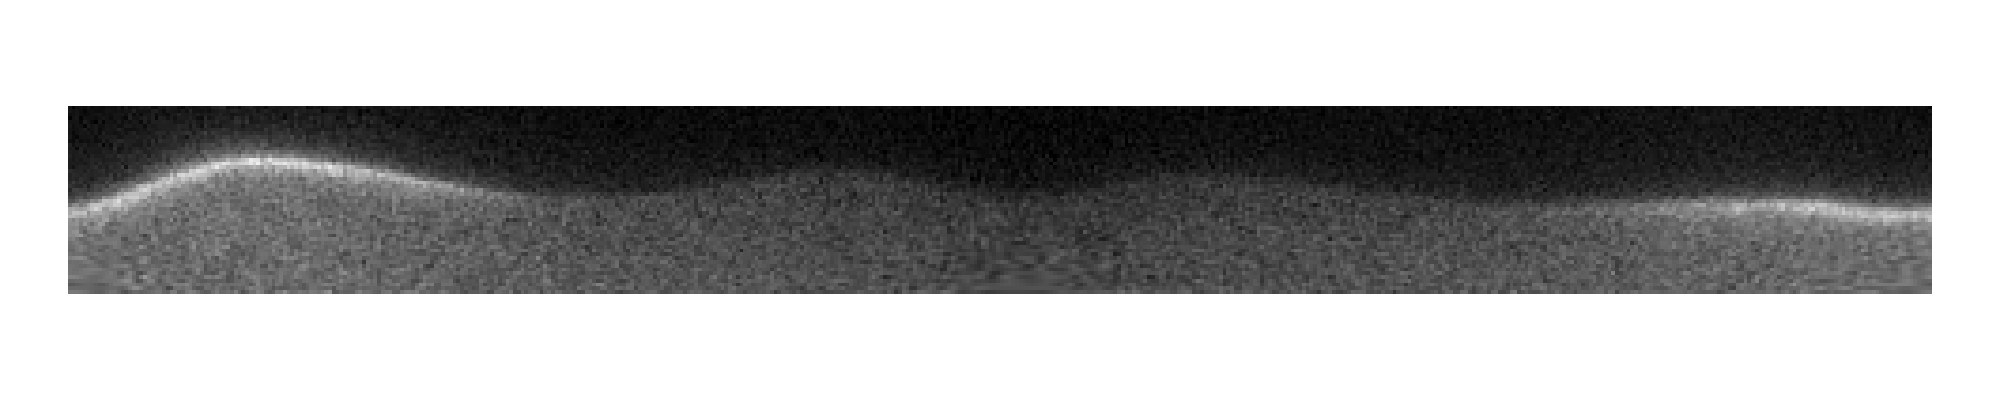

interactive(children=(IntSlider(value=0, description='t', max=59), Output()), _dom_classes=('widget-interact',…

In [8]:
max_width = max(s.shape[1] for s in straights)
print(max_width)
max_intensity = max(np.max(s) for s in straights)

fig, ax = plt.subplots()
@widgets.interact(t=(0, len(straights)-1, 1))
def update(t=0): 
    ax.clear()
    pad_full = max_width - straights[t].shape[1]
    pad_left = int(np.ceil(pad_full/2))
    pad_right = int(pad_full/2)
    straight_padded = np.c_[max_intensity * np.ones([50, pad_left]), straights[t], 
                            max_intensity * np.ones([50, pad_right])]
    ax.imshow(straight_padded, cmap='gray', vmin=0, vmax=max_intensity)
    ax.axis('off')
fig.set_size_inches(10, 2)
fig.tight_layout()

### Animation

In [9]:
# from matplotlib import animation

# fig, ax = plt.subplots()
# fig.set_size_inches(10, 2)
# fig.tight_layout()

# def update(t=0): 
#     ax.clear()
#     pad_full = max_width - straights[t].shape[1]
#     pad_left = int(np.ceil(pad_full/2))
#     pad_right = int(pad_full/2)
#     straight_padded = np.c_[max_intensity * np.ones([50, pad_left]), straights[t], 
#                             max_intensity * np.ones([50, pad_right])]
#     ax.imshow(straight_padded, cmap='gray', vmin=0, vmax=max_intensity)
#     ax.axis('off')


# frames = np.r_[[0], np.arange(0, len(straights)-1,)]
# anim = animation.FuncAnimation(fig, update, frames=iter(frames), save_count=len(frames))
# writer = animation.writers['ffmpeg']
# writer = writer(fps=24, bitrate=2000)
# anim.save('animation.gif', writer=writer, dpi=300)

### Unstraightened figure

<IPython.core.display.Javascript object>


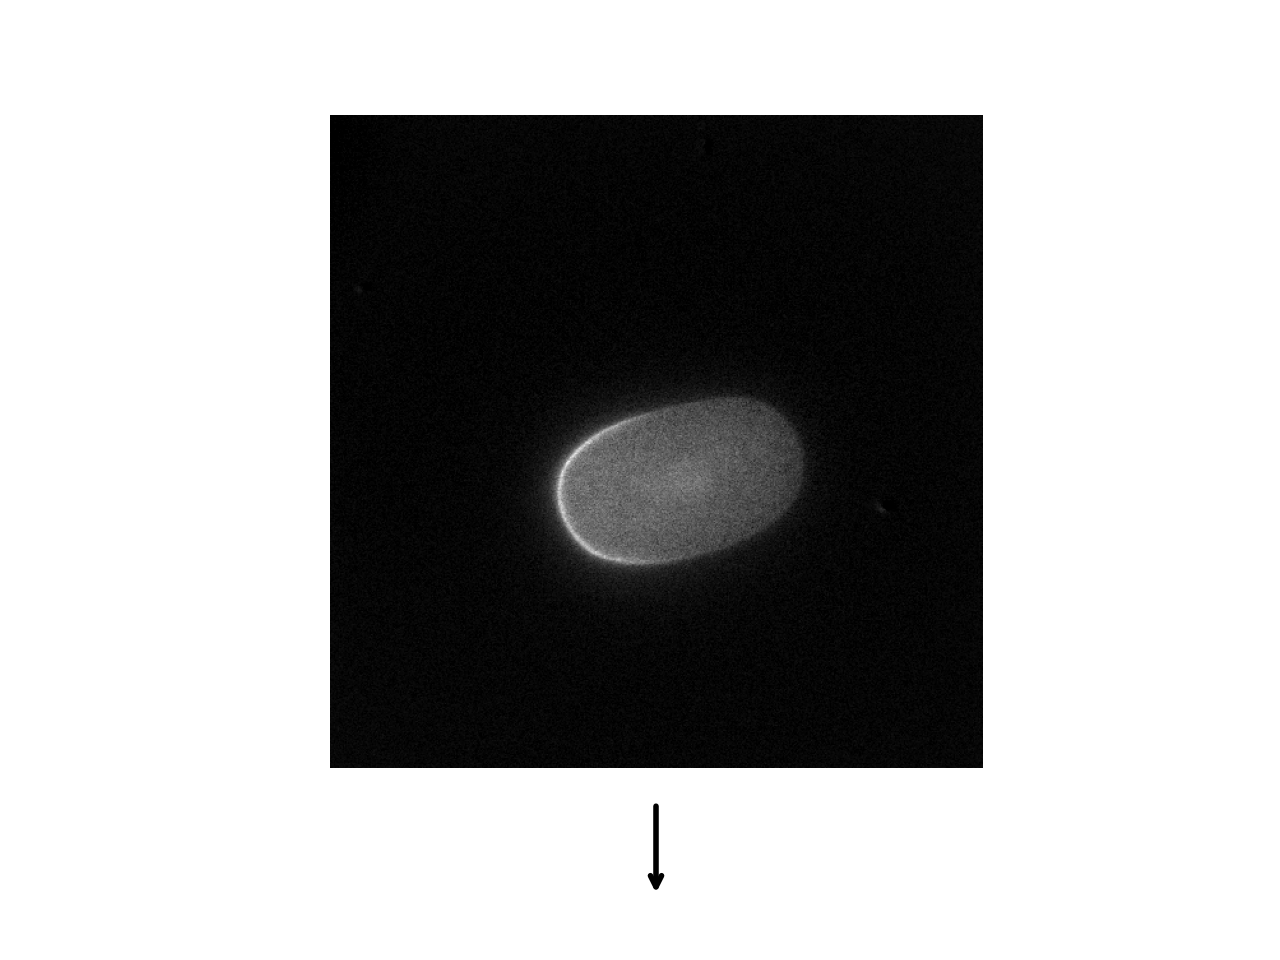

In [28]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray', vmin=0, vmax=max_intensity)
ax.axis('off')
ax.annotate('', xy=(0.5, -0.2), xycoords='axes fraction', xytext=(0.5, -0.05), 
            arrowprops=dict(arrowstyle="->", color='k', linewidth=2))
fig.subplots_adjust(bottom=0.2)
fig.savefig('raw_for_animation.png', dpi=600, transparent=True)